In [ ]:
!pip uninstall qiskit
!pip install qiskit==0.23.0
!pip install pylatexenc

In [1]:
import qiskit
token = '3c648969b4c49d2521944ea0c52d2466348ca185619f2d642d3d12fc3caeb0118c0ac3724f078a784a4e81192decacad79a85d7503a27324ca880e00b2b61662'
qiskit.IBMQ.save_account(token)
account = qiskit.IBMQ.load_account()
provider = qiskit.IBMQ.get_provider(hub='ibm-q')
backend = provider.get_backend('ibmq_qasm_simulator')
print(provider, backend)

configrc.store_credentials:WARNING:2022-09-15 09:28:49,087: Credentials already present. Set overwrite=True to overwrite.


<AccountProvider for IBMQ(hub='ibm-q', group='open', project='main')> ibmq_qasm_simulator


In [2]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt
%matplotlib inline
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F


if torch.cuda.is_available():
  device = torch.device("cuda:0")
  print("Running on the GPU")
else:
  device = torch.device("cpu")
  print("Running on the CPU")

Running on the GPU


In [4]:
#np.random.seed = 314

NUM_QUBITS = 4
NUM_SHOTS = 800 #3000
SHIFT = np.pi/4
LEARNING_RATE = 0.0002
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [5]:
# create list of all possible outputs of quantum circuit (2**NUM_QUBITS possible)
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['0000', '0001', '0010', '0011', '0100', '0101', '0110', '0111', '1000', '1001', '1010', '1011', '1100', '1101', '1110', '1111']


In [6]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas = {k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}

        self.circuit.h(0)
        self.circuit.cx(1, 0)
        self.circuit.cx(2, 1)
        self.circuit.cx(3, 2)

        self.circuit.barrier()

        for k in range(0, 4):
            self.circuit.ry(self.thetas[k], k)

        self.circuit.barrier()

        self.circuit.cx(3, 2)
        self.circuit.cx(2, 1)
        self.circuit.cx(1, 0)
        self.circuit.h(0)

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0)/shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        #print('params = {}'.format(len(params)))
        backend = Aer.get_backend('qasm_simulator')
    
        job_sim = execute(self.circuit,
                              self.backend,
                              shots=self.shots,
                              parameter_binds = [{self.thetas[k] : params[k].item() for k in range(1*NUM_QUBITS)}])
#         
        result_sim = job_sim.result()
        counts = result_sim.get_counts(self.circuit)
        return self.N_qubit_expectation_Z(counts, self.shots, NUM_QUBITS)

/opt/conda/lib/python3.8/site-packages/qiskit/circuit/tools/pi_check.py:49: SymPyDeprecationWarning: 

The expr_free_symbols property is deprecated. Use free_symbols to get
the free symbols of an expression.

See https://docs.sympy.org/latest/explanation/active-deprecations.html#deprecated-expr-free-symbols
for details.

This has been deprecated since SymPy version 1.9. It
will be removed in a future version of SymPy.

  syms = inpt._symbol_expr.expr_free_symbols


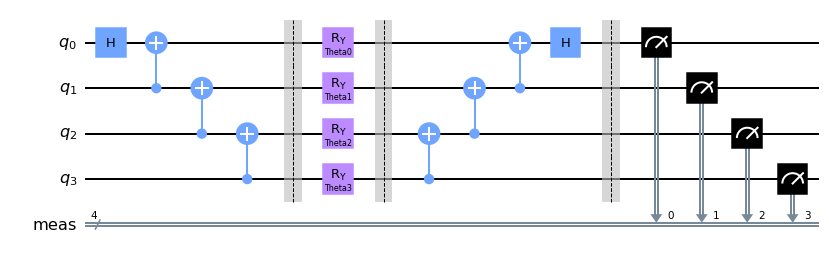

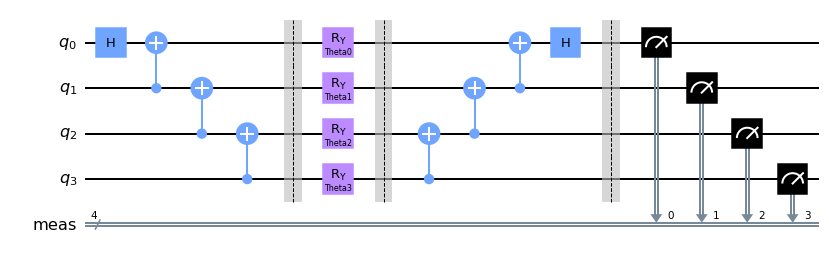

In [7]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
#print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')#, filename='Figures/{}-qubit circuit ryN.jpg'.format(NUM_QUBITS)

In [8]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value], device = device)
  
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
#         print('forward_tensor = {}'.format(forward_tensor))
        input_numbers = i
#         print('input_numbers = {}'.format(input_numbers))
        gradients = torch.Tensor().to(device)
        
        for k in range(1*NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
#             print('shift_right = {}, shift_left = {}'.format(shift_right, shift_left))
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
#             print('expectation_right = {}, \nexpectation_left = {}'.format(expectation_right, expectation_left))
            
            gradient = torch.tensor([expectation_right], device = device) - torch.tensor([expectation_left], device = device)
            # rescale gradient
#             gradient = gradient / torch.norm(gradient)
#             print('gradient for k={}: {}'.format(k, gradient))
            gradients = torch.cat((gradients, gradient.float()))
            
        result = gradients.detach().clone()
#         print('gradients = {}'.format(result))
#         print('grad_output = {}'.format(grad_output))

        return (result.float() * grad_output.float()).T

In [9]:
import sys
sys.path.append('/home/jovyan/QNN4RadarImage/')

In [10]:
from DatasetHandler import DatasetHandler
dataset_root = '/home/jovyan/QNN4RadarImage/datasets/EuroSAT/'
handler = DatasetHandler(dataset_root)

In [11]:
classes = []
for i, c in enumerate(handler.classes):
  cl = c.split('/')[-1]
  classes.append(cl)
classes.sort()
classes

['AnnualCrop',
 'Forest',
 'HerbaceousVegetation',
 'Highway',
 'Industrial',
 'Pasture',
 'PermanentCrop',
 'Residential',
 'River',
 'SeaLake']

In [12]:
imgs_path, imgs_label = handler.load_paths_labels(dataset_root, classes=classes)
print('Dataset images:', len(imgs_path), 'Dataset labels:', len(imgs_label))
print('Dataset sample ->', imgs_path[0], imgs_label[0])

Dataset images: 27000 Dataset labels: 27000
Dataset sample -> /home/jovyan/QNN4RadarImage/datasets/EuroSAT/HerbaceousVegetation/HerbaceousVegetation_1463.jpg 2


In [13]:
train_imgs, train_labels, val_images, val_labels = handler.train_validation_split(imgs_path, imgs_label, split_factor=0.2)
print('X_train shape:', train_imgs.shape, 'Y_train shape:', train_labels.shape)
print('  X_val shape: ', val_images.shape, '  Y_val shape: ', val_labels.shape)

X_train shape: (21600,) Y_train shape: (21600,)
  X_val shape:  (5400,)   Y_val shape:  (5400,)


In [14]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3)

        #self.conv2_drop = nn.Dropout2d()

        self.fc1 = nn.Linear(2304, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 42)

        self.fc4 = nn.Linear(2304, 1*NUM_QUBITS)
        
        self.qc = TorchCircuit.apply

        self.fc5 = nn.Linear(16, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = F.relu(F.max_pool2d(self.conv3(x), 2))

        x = x.view(-1, 2304)
        #x = F.relu(self.fc1(x))
        #x = F.dropout(x, training=self.training)
        #x = F.relu(self.fc2(x))

        #x = F.relu(self.fc3(x))

        x = self.fc4(x)
        x = np.pi*torch.tanh(x)
        
        x = self.qc(x[0]) # QUANTUM LAYER
        
        x = F.relu(x)
        #print('output of QC = {}'.format(x))
        
#         # softmax rather than sigmoid
        x = self.fc5(x.float())
        #print('output of Linear(1, 2): {}'.format(x))
        x = F.softmax(x, 1)

        #x = torch.sigmoid(x)
        #x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        # apply softmax
        pred = self.forward(x)
#         print(pred)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans, device = device)
    
network = Net().to(device)
optimizer = optim.Adam(network.parameters(), lr=0.0002)

In [15]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

#from torchsummary import summary
#summary(network, (3, 64, 64))

In [16]:
train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))

In [ ]:
# checkpoint = torch.load('/content/drive/MyDrive/QAI4EO/model-bell-2.pt')
# checkpoint = torch.load('/home/jovyan/QNN4RadarImage/JSTARS2021/quantum_classifiers/eurosat_classification/saved_models/model-bell-2.pt', map_location=device)
checkpoint = torch.load('/home/jovyan/QNN4RadarImage/JSTARS2021/quantum_classifiers/eurosat_classification/saved_models_new/model-bell-2.pt', map_location=device)
network.load_state_dict(checkpoint['model_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
epoch = checkpoint['epoch']
loss = checkpoint['loss']

In [17]:
train_loss_list = []
val_loss_list = []
epochs = 50

loss_func = nn.CrossEntropyLoss()

for epoch in range(epochs):
  train_loader = iter(handler.qcnn_data_loader(train_imgs, train_labels, batch_size = 1, img_shape = (64,64,3)))
  test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
  total_loss = []
  for batch_idx in range(len(train_labels)):
    data, target = next(train_loader) 
    data = data.to(device)
    target = target.to(device)
    # print(batch_idx)
    optimizer.zero_grad()        
    # Forward pass
    output = network(data)
    # Calculating loss
    loss = loss_func(output, target)
    # Backward pass
    loss.backward()
    loss.detach_()
    # Optimize the weights
    optimizer.step()
    
    total_loss.append(loss.item())
    
    print('\r Epoch %d ~ Batch %d (%d) ~ Loss %f ' % (epoch, batch_idx, len(train_imgs)-1, loss.item()), end='\t\t')
    
    del output
    del loss
  
  with torch.no_grad():
    val_loss = []
    targets = []
    predictions = []
    for batch_idx in range(len(val_images)):
      data, target = next(test_loader)
      data = data.to(device)
      target = target.to(device)
      output = network(data)
      loss = loss_func(output, target)
      loss.detach_()
      val_loss.append(loss.item())
    
      del output
      del loss

      targets.append(target.item())
      
      predictions.append(network.predict(data).item())
  
      
  train_loss_list.append(sum(total_loss)/len(total_loss))
  val_loss_list.append(sum(val_loss)/len(val_loss))
  
  print('Training [{:.0f}%]\t Training Loss: {:.4f} Validation Loss: {:.4f}'.format(
      100. * (epoch + 1) / epochs, train_loss_list[-1], val_loss_list[-1]))
  
  if epoch % 3 == 1:
    print(confusion_matrix(targets, predictions,normalize='true'))
    print(classification_report(targets, predictions, target_names=classes, digits=4))
    torch.save({
            'epoch': epoch,
            'model_state_dict': network.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss_list[-1],
            }, '/home/jovyan/QNN4RadarImage/JSTARS2021/quantum_classifiers/eurosat_classification/saved_models_new/model-bell-2.pt')
    #torch.save(network.state_dict(), '/content/drive/MyDrive/QAI4EO/model-bell.pt')

 Epoch 0 ~ Batch 21599 (21599) ~ Loss 2.292982 		Training [2%]	 Training Loss: 2.2588 Validation Loss: 2.2262
 Epoch 1 ~ Batch 21599 (21599) ~ Loss 2.336291 		Training [4%]	 Training Loss: 2.1990 Validation Loss: 2.1550
[[0.0053286  0.09236234 0.68383659 0.         0.0017762  0.
  0.         0.12611012 0.         0.09058615]
 [0.         0.99174917 0.         0.         0.         0.
  0.         0.         0.         0.00825083]
 [0.         0.03040541 0.58614865 0.         0.01013514 0.
  0.         0.29560811 0.         0.0777027 ]
 [0.01221996 0.00814664 0.20366599 0.         0.05906314 0.
  0.         0.6802444  0.         0.03665988]
 [0.         0.         0.         0.         0.92936803 0.
  0.         0.07063197 0.         0.        ]
 [0.00490196 0.51715686 0.26470588 0.         0.         0.
  0.         0.02696078 0.         0.18627451]
 [0.         0.00195312 0.39257812 0.         0.01757812 0.
  0.         0.58789062 0.         0.        ]
 [0.         0.         0.     

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Epoch 2 ~ Batch 21599 (21599) ~ Loss 1.762461 		Training [6%]	 Training Loss: 2.1286 Validation Loss: 2.1005
 Epoch 3 ~ Batch 21599 (21599) ~ Loss 2.411288 		Training [8%]	 Training Loss: 2.0637 Validation Loss: 2.0258
 Epoch 4 ~ Batch 21599 (21599) ~ Loss 2.439612 		Training [10%]	 Training Loss: 2.0126 Validation Loss: 1.9931
[[0.90875912 0.05291971 0.         0.         0.         0.
  0.         0.         0.         0.03832117]
 [0.00165563 0.80960265 0.         0.         0.         0.
  0.         0.         0.         0.18874172]
 [0.78267717 0.06299213 0.         0.         0.00472441 0.
  0.         0.1007874  0.         0.0488189 ]
 [0.56653992 0.12547529 0.         0.         0.05703422 0.
  0.         0.2338403  0.         0.01711027]
 [0.01577909 0.         0.         0.         0.78106509 0.
  0.         0.20315582 0.         0.        ]
 [0.33157895 0.46842105 0.         0.         0.         0.
  0.         0.         0.         0.2       ]
 [0.91106291 0.01301518 0. 

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Epoch 5 ~ Batch 16594 (21599) ~ Loss 1.514604 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 8 ~ Batch 16743 (21599) ~ Loss 1.478347 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 11 ~ Batch 16717 (21599) ~ Loss 1.671653 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 13 ~ Batch 21599 (21599) ~ Loss 1.481861 		Training [28%]	 Training Loss: 1.7352 Validation Loss: 1.7943
[[0.72837022 0.01810865 0.03420523 0.00804829 0.00201207 0.
  0.06841046 0.01207243 0.10462777 0.02414487]
 [0.         0.58513932 0.03250774 0.         0.         0.
  0.         0.         0.01083591 0.37151703]
 [0.         0.00153846 0.76615385 0.04       0.00615385 0.
  0.08       0.09692308 0.00923077 0.        ]
 [0.01351351 0.01158301 0.06756757 0.68146718 0.06949807 0.
  0.03667954 0.07528958 0.04440154 0.        ]
 [0.00192308 0.         0.         0.00192308 0.86346154 0.
  0.00576923 0.125      0.00192308 0.        ]
 [0.005      0.2        0.165      0.1475     0.         0.
  0.0425     0.0025     0.3575     0.08      ]
 [0.06352459 0.00204918 0.42827869 0.06352459 0.02254098 0.
  0.33606557 0.04098361 0.04303279 0.        ]
 [0.         0.         0.         0.00152439 0.01676829 0.
  0.00152439 0.98018293 0.         0.        ]
 [0.0210084  0.0210084  0.033613

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Epoch 14 ~ Batch 9189 (21599) ~ Loss 1.522728 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 16 ~ Batch 21599 (21599) ~ Loss 1.655195 		Training [34%]	 Training Loss: 1.7019 Validation Loss: 1.7169
[[0.8657845  0.01323251 0.00189036 0.00189036 0.00567108 0.
  0.07561437 0.         0.03213611 0.00378072]
 [0.         0.93264249 0.00863558 0.         0.         0.
  0.00345423 0.         0.02763385 0.02763385]
 [0.0066335  0.01160862 0.68325041 0.05804312 0.01160862 0.
  0.15422886 0.01658375 0.05472637 0.00331675]
 [0.02680412 0.         0.01030928 0.70927835 0.05360825 0.
  0.10515464 0.01030928 0.08453608 0.        ]
 [0.         0.         0.         0.00366972 0.95779817 0.
  0.01284404 0.0146789  0.01100917 0.        ]
 [0.15308642 0.24938272 0.07407407 0.01234568 0.00246914 0.
  0.14814815 0.         0.31851852 0.04197531]
 [0.13069307 0.0039604  0.13663366 0.04752475 0.01188119 0.
  0.61782178 0.         0.05148515 0.        ]
 [0.00310078 0.         0.00620155 0.00310078 0.08217054 0.
  0.00620155 0.89767442 0.00155039 0.        ]
 [0.08080808 0.0020202  0.008080

/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


 Epoch 17 ~ Batch 8917 (21599) ~ Loss 2.261207 		

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 19 ~ Batch 21599 (21599) ~ Loss 1.463682 		Training [40%]	 Training Loss: 1.6710 Validation Loss: 1.7115
[[0.84320557 0.00696864 0.         0.00522648 0.02787456 0.
  0.05749129 0.00522648 0.04878049 0.00522648]
 [0.01393728 0.8466899  0.01219512 0.         0.         0.
  0.00348432 0.         0.0261324  0.09756098]
 [0.02321981 0.01393189 0.6377709  0.06037152 0.00464396 0.
  0.2120743  0.02321981 0.02321981 0.00154799]
 [0.01461378 0.         0.00208768 0.77661795 0.08977035 0.
  0.03549061 0.01043841 0.07098121 0.        ]
 [0.         0.         0.00194175 0.02912621 0.93592233 0.
  0.0038835  0.02330097 0.00582524 0.        ]
 [0.22632794 0.14549654 0.02540416 0.02078522 0.00692841 0.02078522
  0.13856813 0.         0.31177829 0.1039261 ]
 [0.13291139 0.0021097  0.03586498 0.05907173 0.03586498 0.
  0.64556962 0.03375527 0.05485232 0.        ]
 [0.         0.         0.0046729  0.00778816 0.04361371 0.
  0.00311526 0.93925234 0.00155763 0.        ]
 [0.03950104 0.004158   

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 22 ~ Batch 21599 (21599) ~ Loss 1.466813 		Training [46%]	 Training Loss: 1.6357 Validation Loss: 1.6887
[[0.79562044 0.00547445 0.01277372 0.01094891 0.01642336 0.05109489
  0.0620438  0.         0.03467153 0.01094891]
 [0.         0.92586751 0.02996845 0.         0.         0.03785489
  0.         0.         0.00157729 0.00473186]
 [0.00451128 0.01353383 0.7037594  0.06766917 0.00601504 0.02406015
  0.13082707 0.04511278 0.00150376 0.00300752]
 [0.00627615 0.         0.0041841  0.81380753 0.09414226 0.
  0.0334728  0.03556485 0.0125523  0.        ]
 [0.00205761 0.         0.         0.01851852 0.92386831 0.
  0.00205761 0.05144033 0.00205761 0.        ]
 [0.05753425 0.06027397 0.03561644 0.05479452 0.         0.51780822
  0.1260274  0.         0.13424658 0.01369863]
 [0.08639706 0.         0.14889706 0.07720588 0.01838235 0.01102941
  0.62316176 0.02573529 0.00919118 0.        ]
 [0.         0.         0.00338409 0.00676819 0.05076142 0.
  0.         0.93908629 0.         0.  

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 25 ~ Batch 21599 (21599) ~ Loss 1.466315 		Training [52%]	 Training Loss: 1.6178 Validation Loss: 1.6883
[[0.7247191  0.01498127 0.01123596 0.00374532 0.01498127 0.08614232
  0.09550562 0.         0.02621723 0.02247191]
 [0.         0.8557047  0.01342282 0.         0.         0.0033557
  0.         0.         0.00167785 0.12583893]
 [0.0033389  0.03672788 0.81469115 0.03505843 0.01001669 0.0066778
  0.06844741 0.02337229 0.         0.00166945]
 [0.0021978  0.         0.05274725 0.83296703 0.04395604 0.01538462
  0.02637363 0.01978022 0.00659341 0.        ]
 [0.         0.         0.         0.02033272 0.93715342 0.
  0.012939   0.02402957 0.00554529 0.        ]
 [0.02137767 0.19477435 0.10688836 0.01900238 0.         0.50356295
  0.05463183 0.         0.0807601  0.01900238]
 [0.0245283  0.01509434 0.35660377 0.03773585 0.00377358 0.03018868
  0.51886792 0.00377358 0.00566038 0.00377358]
 [0.         0.         0.00983607 0.         0.0295082  0.
  0.00655738 0.95409836 0.       

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 28 ~ Batch 21599 (21599) ~ Loss 1.482008 		Training [58%]	 Training Loss: 1.6062 Validation Loss: 1.6372
[[0.82495667 0.01559792 0.00519931 0.01386482 0.01213172 0.06412478
  0.04679376 0.         0.01039861 0.00693241]
 [0.         0.96314103 0.00961538 0.         0.         0.01121795
  0.         0.         0.00480769 0.01121795]
 [0.00312989 0.02816901 0.76056338 0.02660407 0.00938967 0.0172144
  0.13302034 0.0172144  0.         0.00469484]
 [0.01968504 0.         0.00590551 0.81299213 0.04330709 0.00787402
  0.05905512 0.02362205 0.02755906 0.        ]
 [0.00369004 0.         0.         0.02214022 0.9298893  0.
  0.00369004 0.03690037 0.00369004 0.        ]
 [0.0741688  0.09462916 0.06393862 0.01278772 0.01278772 0.61636829
  0.04347826 0.         0.06393862 0.01790281]
 [0.07792208 0.00649351 0.13419913 0.01948052 0.01298701 0.02164502
  0.7012987  0.01298701 0.01298701 0.        ]
 [0.         0.         0.0033389  0.00500835 0.02838063 0.
  0.01168614 0.95158598 0.      

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 31 ~ Batch 21599 (21599) ~ Loss 1.597283 		Training [64%]	 Training Loss: 1.5921 Validation Loss: 1.6502
[[0.81314879 0.00346021 0.00519031 0.0017301  0.00519031 0.07439446
  0.04152249 0.00346021 0.0449827  0.00692042]
 [0.         0.94207836 0.01703578 0.         0.         0.01192504
  0.         0.         0.00511073 0.02385009]
 [0.00793651 0.02857143 0.77460317 0.01587302 0.00793651 0.01587302
  0.13492063 0.01111111 0.0031746  0.        ]
 [0.00401606 0.         0.04016064 0.81325301 0.04216867 0.00803213
  0.06024096 0.00401606 0.02811245 0.        ]
 [0.         0.         0.         0.01414141 0.95353535 0.
  0.00808081 0.02020202 0.0040404  0.        ]
 [0.07529412 0.12       0.04705882 0.00235294 0.         0.66823529
  0.02823529 0.         0.05647059 0.00235294]
 [0.10869565 0.00395257 0.14822134 0.0256917  0.01185771 0.07114625
  0.59881423 0.00197628 0.02766798 0.00197628]
 [0.         0.         0.01166667 0.00166667 0.04666667 0.
  0.03333333 0.90666667 0.     

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 34 ~ Batch 21599 (21599) ~ Loss 1.463130 		Training [70%]	 Training Loss: 1.5815 Validation Loss: 1.6440
[[0.83215548 0.00353357 0.00353357 0.00353357 0.00706714 0.05830389
  0.06183746 0.         0.01766784 0.01236749]
 [0.         0.87979967 0.01502504 0.         0.         0.02838063
  0.         0.         0.00166945 0.07512521]
 [0.00631912 0.01737757 0.69352291 0.04107425 0.00473934 0.06319115
  0.13586098 0.01737757 0.01737757 0.00315956]
 [0.         0.00205339 0.00821355 0.87063655 0.03080082 0.01232033
  0.03080082 0.00821355 0.03696099 0.        ]
 [0.         0.         0.         0.01584158 0.95049505 0.
  0.00792079 0.02574257 0.         0.        ]
 [0.06651885 0.05321508 0.02217295 0.00221729 0.00665188 0.70509978
  0.07317073 0.         0.03991131 0.03104213]
 [0.06477733 0.00607287 0.05668016 0.04251012 0.00607287 0.06882591
  0.72874494 0.00404858 0.02024291 0.00202429]
 [0.         0.         0.00522648 0.01045296 0.06968641 0.
  0.03135889 0.8815331  0.00174

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 37 ~ Batch 21599 (21599) ~ Loss 1.468247 		Training [76%]	 Training Loss: 1.5746 Validation Loss: 1.6555
[[0.78481013 0.00904159 0.00361664 0.01084991 0.01084991 0.07775769
  0.06329114 0.         0.03435805 0.00542495]
 [0.         0.92833333 0.01833333 0.         0.         0.02666667
  0.         0.         0.005      0.02166667]
 [0.         0.02298851 0.83087028 0.0410509  0.00164204 0.01313629
  0.05582923 0.03119869 0.00164204 0.00164204]
 [0.01212121 0.         0.03838384 0.82222222 0.04444444 0.01010101
  0.01818182 0.03636364 0.01818182 0.        ]
 [0.         0.         0.00417537 0.01043841 0.87682672 0.
  0.00835073 0.10020877 0.         0.        ]
 [0.03855422 0.04578313 0.05783133 0.         0.00240964 0.6939759
  0.03614458 0.         0.11084337 0.01445783]
 [0.042      0.01       0.314      0.022      0.016      0.056
  0.502      0.01       0.028      0.        ]
 [0.         0.         0.00149477 0.00149477 0.02989537 0.
  0.00298954 0.96412556 0.         0.

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 40 ~ Batch 21599 (21599) ~ Loss 1.462031 		Training [82%]	 Training Loss: 1.5692 Validation Loss: 1.6356
[[0.82909091 0.00363636 0.00727273 0.00181818 0.00727273 0.06363636
  0.06181818 0.         0.02363636 0.00181818]
 [0.         0.87993421 0.01809211 0.         0.         0.03289474
  0.00164474 0.         0.00164474 0.06578947]
 [0.00322581 0.00806452 0.76935484 0.0516129  0.00967742 0.02258065
  0.1016129  0.02580645 0.00483871 0.00322581]
 [0.00206612 0.         0.00206612 0.85950413 0.02479339 0.01239669
  0.05165289 0.00619835 0.04132231 0.        ]
 [0.         0.         0.         0.03640257 0.90792291 0.
  0.01498929 0.0385439  0.00214133 0.        ]
 [0.05263158 0.04210526 0.03947368 0.02105263 0.         0.74210526
  0.03947368 0.         0.05789474 0.00526316]
 [0.06954887 0.0018797  0.14097744 0.02631579 0.0075188  0.02443609
  0.70112782 0.0056391  0.02255639 0.        ]
 [0.         0.         0.01076923 0.01230769 0.04923077 0.
  0.00769231 0.92       0.     

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 43 ~ Batch 21599 (21599) ~ Loss 1.462999 		Training [88%]	 Training Loss: 1.5619 Validation Loss: 1.6350
[[0.80662021 0.         0.00522648 0.         0.0261324  0.05400697
  0.05923345 0.         0.04006969 0.0087108 ]
 [0.         0.92006525 0.01305057 0.         0.         0.04730832
  0.00163132 0.         0.00978793 0.00815661]
 [0.00468019 0.00624025 0.79407176 0.05460218 0.00780031 0.04212168
  0.05772231 0.02028081 0.00936037 0.00312012]
 [0.00617284 0.         0.01234568 0.81893004 0.05761317 0.03497942
  0.01646091 0.01440329 0.03909465 0.        ]
 [0.         0.         0.         0.0214425  0.95126706 0.
  0.00779727 0.01754386 0.00194932 0.        ]
 [0.03743316 0.00534759 0.01871658 0.00534759 0.00534759 0.73262032
  0.05347594 0.         0.13368984 0.00802139]
 [0.07874016 0.0019685  0.17716535 0.04527559 0.02362205 0.06299213
  0.55708661 0.00984252 0.04133858 0.0019685 ]
 [0.00157233 0.         0.         0.02672956 0.0990566  0.
  0.01100629 0.86163522 0.     

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 46 ~ Batch 21599 (21599) ~ Loss 2.459842 		Training [94%]	 Training Loss: 1.5594 Validation Loss: 1.6350
[[0.82574257 0.00594059 0.0039604  0.0039604  0.00594059 0.08316832
  0.04554455 0.         0.01584158 0.00990099]
 [0.         0.92753623 0.00905797 0.         0.         0.03442029
  0.         0.         0.00543478 0.02355072]
 [0.00458015 0.00458015 0.76335878 0.03664122 0.00305344 0.03664122
  0.11145038 0.0259542  0.00916031 0.00458015]
 [0.00982318 0.         0.00392927 0.83104126 0.06679764 0.00982318
  0.043222   0.00785855 0.02750491 0.        ]
 [0.00383877 0.         0.         0.02303263 0.9328215  0.
  0.00959693 0.02495202 0.00575816 0.        ]
 [0.03217822 0.00247525 0.02475248 0.         0.         0.7549505
  0.06930693 0.         0.11386139 0.00247525]
 [0.09320388 0.00194175 0.13398058 0.01747573 0.0038835  0.05436893
  0.66213592 0.01359223 0.01941748 0.        ]
 [0.         0.         0.00963082 0.00802568 0.0529695  0.
  0.00802568 0.92134831 0.      

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



 Epoch 49 ~ Batch 21599 (21599) ~ Loss 1.463833 		Training [100%]	 Training Loss: 1.5520 Validation Loss: 1.6524
[[0.75724638 0.01086957 0.00543478 0.00181159 0.01449275 0.07608696
  0.12137681 0.         0.01086957 0.00181159]
 [0.         0.94664634 0.0320122  0.         0.         0.01981707
  0.         0.         0.00152439 0.        ]
 [0.00847458 0.01016949 0.71186441 0.0220339  0.01186441 0.01355932
  0.19491525 0.02542373 0.00169492 0.        ]
 [0.00394477 0.         0.01183432 0.78303748 0.07495069 0.00394477
  0.0591716  0.05128205 0.01183432 0.        ]
 [0.00205339 0.         0.         0.         0.95071869 0.
  0.02464066 0.02053388 0.00205339 0.        ]
 [0.01643192 0.07276995 0.0258216  0.01877934 0.00234742 0.72769953
  0.08215962 0.         0.05164319 0.00234742]
 [0.09072165 0.00412371 0.07010309 0.01443299 0.01237113 0.03917526
  0.74226804 0.02268041 0.00412371 0.        ]
 [0.         0.         0.00451807 0.00301205 0.06927711 0.
  0.01656627 0.90662651 0.    

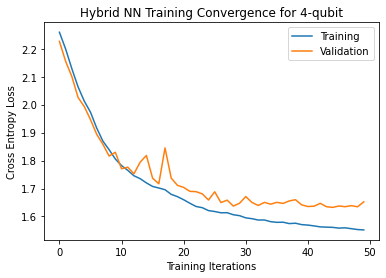

In [18]:
plt.plot(train_loss_list)
plt.plot(val_loss_list)
plt.title('Hybrid NN Training Convergence for {}-qubit'.format(NUM_QUBITS))
plt.xlabel('Training Iterations')
plt.ylabel('Cross Entropy Loss')
plt.legend(['Training', 'Validation'])
plt.show()

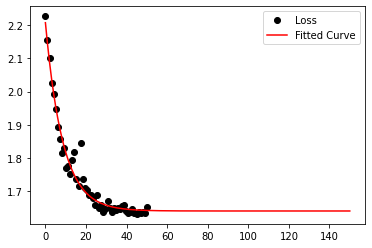

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

def func(x, a, b, c):
  return a * np.exp(-b * x) + c

x = np.linspace(0,len(train_loss_list),len(train_loss_list))
y = func(x, 2.5, 1.3, 0.5)
yn = np.array(val_loss_list)

popt, pcov = curve_fit(func, x, yn)

plt.figure()
x1 = np.linspace(0,100+len(train_loss_list),100+len(train_loss_list))
plt.plot(x, yn, 'ko', label="Loss")
plt.plot(x1, func(x1, *popt), 'r-', label="Fitted Curve")
plt.legend()
plt.show()

In [21]:
test_loader = iter(handler.qcnn_data_loader(val_images, val_labels, batch_size = 1, img_shape = (64,64,3)))
accuracy = 0
number = 0

predictions = []
targets = []

for ct in range(len(val_images)):

  data, target = next(test_loader)
  data = data.to(device)
  target = target.to(device)
  number +=1
  output = network.predict(data).item()
  
  predictions.append(output)
  targets.append(target.item())
  
  accuracy += (output == target[0].item())*1
  print('\r ' + str(ct), end='')

 5399

(array([591., 589., 604., 511., 528., 430., 491., 611., 482., 563.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

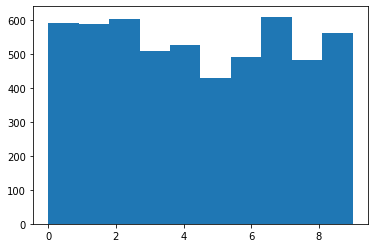

In [22]:
plt.hist(targets, bins = 10)

In [23]:
print("Performance on test data is : {}/{} = {}%".format(accuracy,number,100*accuracy/number))

Performance on test data is : 4409/5400 = 81.64814814814815%


In [24]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
cm = confusion_matrix(targets, predictions,normalize='true')

S2
Accuracy: [0.7749577  0.93887946 0.71357616 0.7592955  0.92234848 0.70697674
 0.74338086 0.92307692 0.70954357 0.91829485] mean:  0.8110330238480197
                      precision    recall  f1-score   support

          AnnualCrop     0.8373    0.7750    0.8049       591
              Forest     0.9021    0.9389    0.9201       589
HerbaceousVegetation     0.7967    0.7136    0.7528       604
             Highway     0.7823    0.7593    0.7706       511
          Industrial     0.8311    0.9223    0.8743       528
             Pasture     0.6696    0.7070    0.6878       430
       PermanentCrop     0.5868    0.7434    0.6559       491
         Residential     0.8868    0.9231    0.9046       611
               River     0.8953    0.7095    0.7917       482
             SeaLake     0.9885    0.9183    0.9521       563

            accuracy                         0.8165      5400
           macro avg     0.8176    0.8110    0.8115      5400
        weighted avg     0.8244    0.816

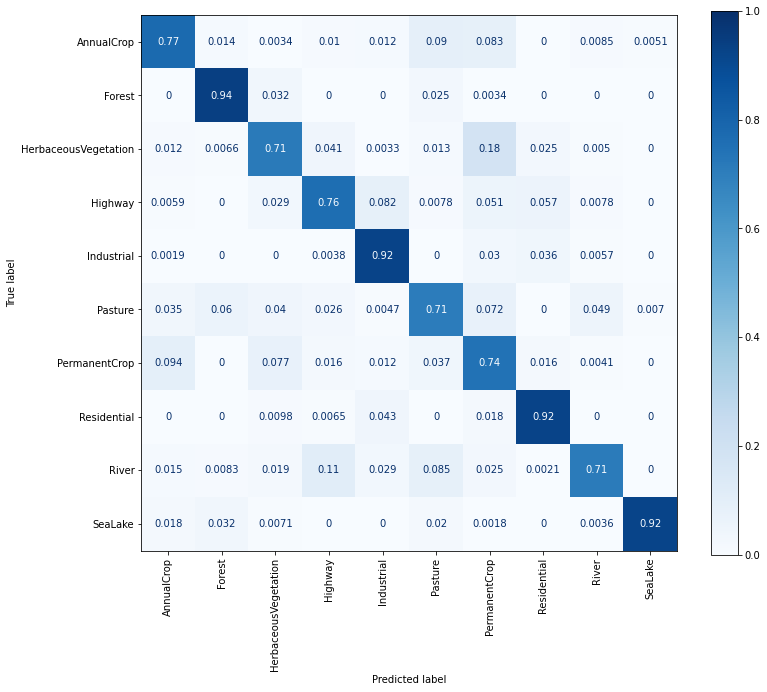

In [25]:
fig, axes = plt.subplots(nrows = 1, ncols = 1, figsize = (12,10))

cmd = ConfusionMatrixDisplay(cm, display_labels=classes)
cmd.plot(ax=axes, cmap='Blues', xticks_rotation='vertical')
print('S2')
print('Accuracy:', cm.diagonal(), 'mean: ', cm.diagonal().mean())
print(classification_report(targets, predictions, target_names=classes, digits=4))
axes.get_images()[0].set_clim(0, 1)
plt.show()
plt.close()